<a href="https://colab.research.google.com/github/Sepali21/Finanzas-Computacionales/blob/main/Trabajo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimización de portafolio cripto y simulación
Sebastian Parraga - Maria Fernanda Gutierrez - Cristián Vega

In [3]:
!pip install --quiet yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import cvxpy as cp
import statsmodels.api as sm
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
!pip install fitter
from fitter import Fitter, get_common_distributions, get_distributions

     |████████████████████████████████| 62 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fitter: filename=fitter-1.5.1-py3-none-any.whl size=25595 sha256=f9cf134b3bd0fe756f3664c3de9e02d69ca62be4a72df49dd1d710f540602b20
  Stored in directory: /root/.cache/pip/wheels/40/65/62/57b872ba7af36e70111b1f67cffe76f97c747804aff7665ccb
Successfully built fitter


In [47]:
#Eleccion de datos para crear el portafolio cripto: Bitcoin, Etherium, Litecoin y Tether
start = '2010-12-31'
end = '2021-12-31'
assets = ['BTC-USD','ETH-USD','LTC-USD','USDT-USD']
precios = yf.download(assets, start = start, end = end,interval='1Mo')['Adj Close'].dropna()
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
cov = retornos.cov()
var = np.diag(cov)
sigma = np.sqrt(var)
n = len(mu)

[*********************100%***********************]  4 of 4 completed


In [ ]:
warnings.filterwarnings("ignore")
!pip install riskfolio-lib
import riskfolio.RiskFunctions as rk


#Optimización Omega

In [59]:

threshold = retornos.loc[retornos.index[-1]]
def omega(df,threshold):
  dailythreshold = (threshold + 1)**np.sqrt(1/252)-1
  df['return']= retornos
  df['excess'] = df['return'] - dailythreshold
  dfpositivesum = (df[df['excess']>0].sum())['excess']
  dfnegativesum = (df[df['excess']<0].sum())['excess']
  omega = dfpositivesum/(-dfnegativesum)
  return omega

In [60]:
omega(retornos, threshold)

ValueError: ignored

In [56]:

threshold = retornos.loc[retornos.index[-1]]
threshold

BTC-USD    -0.207865
ETH-USD    -0.229248
LTC-USD    -0.350482
USDT-USD   -0.000097
Name: 2021-12-01 00:00:00, dtype: float64

##Simulación de Montecarlo

<function matplotlib.pyplot.show(*args, **kw)>

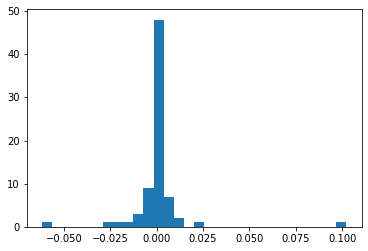

In [ ]:
w = cp.Variable(n)
risk = cp.quad_form(w,cov)
objective =cp. Minimize(risk)
constraints = [cp.sum(w)==1, w>=0]
opt = cp.Problem(objective, constraints)
opt.solve()
wpmvg = w.value
ret_port = retornos @ wpmvg
plt.hist(ret_port, bins=30)
plt.show

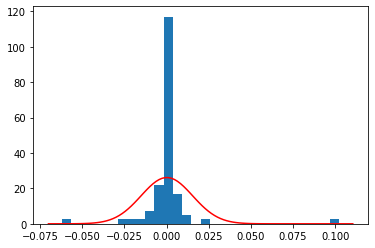

In [ ]:
rp = ret_port.mean() #Diario
sigmap = ret_port.std()
rp, sigmap
plt.hist(ret_port, bins=30, density=True)
#Percentiles de la distribución normal
xmin, xmax = plt.xlim()
xmin, xmax 
x = np.linspace (xmin,xmax,100)
px =norm.pdf(x,rp,sigmap)
plt.plot(x,px,"r")

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 16.13it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,4126.164420,148.357159,309.206133,inf,0.060671,9.295614e-01
lognorm,45618.665763,422.347508,493.746274,inf,0.261039,5.355751e-05
chi2,45817.126809,426.949156,494.071849,inf,0.263575,4.353673e-05
norm,46432.176089,501.386784,490.754464,inf,0.278855,1.194390e-05
exponpow,55807.442866,-115.554711,508.865545,inf,0.364448,1.954448e-09


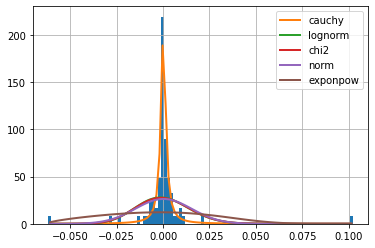

In [ ]:
frp = Fitter(ret_port, distributions=get_common_distributions())
frp.fit()
frp.summary()

In [ ]:
frp.get_best(method = 'sumsquare_error')

{'cauchy': {'loc': 0.00012604585740899572, 'scale': 0.0015679586712088603}}

Por el criterio BIC, luego de realizar la simulación de Montecarlo para obtener los datos, se escoge la distribución cauchy que representa mejor los datos. El parámetro de ubicación es 0.0012604585740899572, que hace referencia a la mediana de la muestra, y el parámetro de escala es 0.0015679586712088603, que hace referencia a un tipo de curtosis.

##Simulación proceso estocástico movimiento geométrico browniano

In [ ]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    St = S # {"S":S} 
    return St

##Pesos

In [ ]:

def random_portfolios(n_portfolios, mu, cov, rf):
    medidas = np.zeros((3,n_portfolios))
    weight_array = []
    for i in range(n_portfolios):
      weights = np.random.random(4)
      weights /= np.sum(weights)
      weight_array.append(weights)
      retorno = np.sum(mu*weights ) * 12
      std_dev = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
      medidas[0,i] = std_dev
      medidas[1,i] = retorno
      # Sharpe ratio
      medidas[2,i] = (retorno - rf) / std_dev
    return weights
pesos=random_portfolios(n_portfolios,mu, cov,  rf)
S0=np.dot(pesos,precios.iloc[-1])
mu = retornos.mean()
mu=np.dot(pesos,mu)
sigma=np.dot(pesos,sigma)
S0

10228.553407238169

In [ ]:
mu = retornos.mean()
mu=np.dot(pesos,mu)
sigma

0.16945996711457853

##10.000 trayectorias con T = 1 año

In [ ]:
T = 1
sigma = sigma
mu = mu
S0 = S0
NS = 10000
M = 12
St = PathsGBM(S0,mu,sigma,T,NS,M)
St

array([[10228.55340724, 10763.57030963, 10983.80998258, ...,
        10348.97122705,  9646.29907735,  9382.34495222],
       [10228.55340724, 10229.89875403, 10002.68129024, ...,
         9540.15668195,  9097.15458541,  9133.09318232],
       [10228.55340724,  9891.28800754, 10086.79426492, ...,
        11851.25373804, 11170.52427573, 11315.6266722 ],
       ...,
       [10228.55340724, 10195.46328092,  9895.79810319, ...,
         9245.30907507,  9267.79099037,  9460.26883932],
       [10228.55340724, 10066.20291144, 10523.24602297, ...,
        10492.1850214 , 10926.79121069, 11247.07762617],
       [10228.55340724,  9880.85564855, 10471.21853809, ...,
        13131.85031102, 13870.61700773, 13808.35517228]])

Text(0, 0.5, 'S(t)')

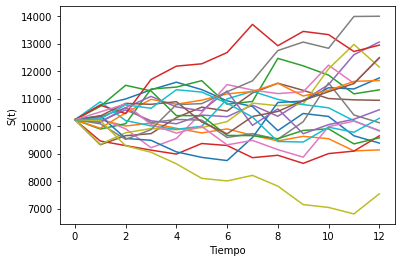

In [ ]:
#Primeras 20 trayectorias
plt.plot(np.transpose(St[0:20,:])) 
plt.xlabel("Tiempo")
plt.ylabel("S(t)")

In [ ]:
S0 * np.exp(mu*T)
#Probabilidad de que los retornos del portafolio sean inferiores a cero
prob = pd.DataFrame(retornos.iloc[-1,:] < 0).value_counts() / NS
prob

2021-12-01 00:00:00
True                   0.0004
dtype: float64

Según los resultados, la probabilidad de que los retornos del portafolio de criptos sea menor a 0, es de 0,04%, por lo cual se recomienda invertir.

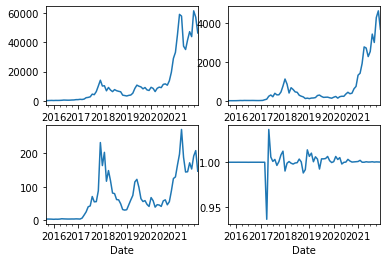

In [ ]:
#las distribuciones del precio para las criptos elegidas
plt.subplot(2, 2, 1)
precios['BTC-USD'].plot()
plt.subplot(2, 2, 2)
precios['ETH-USD'].plot()
plt.subplot(2, 2, 3)
precios['LTC-USD'].plot()
plt.subplot(2, 2, 4)
precios['USDT-USD'].plot()
plt.show()

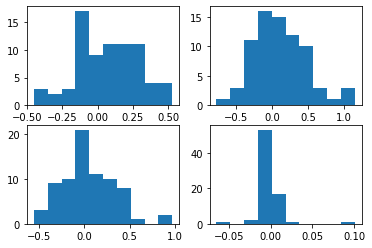

In [ ]:
#Grafica de los retornos
plt.subplot(2, 2, 1)
plt.hist(retornos['BTC-USD'],bins=10)
plt.subplot(2, 2, 2)
plt.hist(retornos['ETH-USD'],bins=10)
plt.subplot(2, 2, 3)
plt.hist(retornos['LTC-USD'],bins=10)
plt.subplot(2, 2, 4)
plt.hist(retornos['USDT-USD'],bins=10)
plt.show()

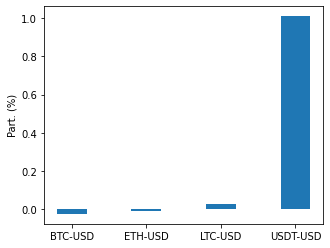

In [ ]:
# Portafolio de mínima varianza global de Markowitz para las criptos
def pmvg(cov, ones):  
    cov_inv = np.linalg.inv(cov)  
    w = np.dot(cov_inv, ones)  
    return w / np.sum(w) 

unos = np.repeat(1,n)
wpmvg = pmvg(cov, unos)

fig = plt.figure(figsize = (5, 4))
plt.bar(assets, wpmvg, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

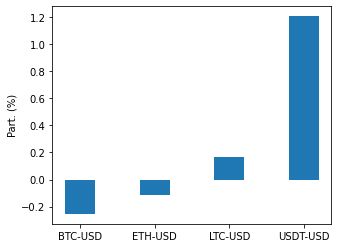

In [ ]:
# Portafolio de máximo Sharpe para las criptos
def pmsharpe(cov, mu, rf):  
    r = mu - rf 
    z = np.linalg.solve(cov,r) 
    return z / np.sum(z) 

rf = 0
wpt = pmsharpe(cov, mu, rf)
fig = plt.figure(figsize = (5, 4))
plt.bar(assets, wpt, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [ ]:
wpt

array([-0.25387107, -0.11375149,  0.16286905,  1.20475351])

# Generación de portfolios cripto: aleatorios y tangente
## Portafolio de máx. Sharpe

In [ ]:
def random_portfolios(n_portfolios, mu, cov, rf):
    medidas = np.zeros((3,n_portfolios))
    weight_array = []
    for i in range(n_portfolios):
      weights = np.random.random(4)
      weights /= np.sum(weights)
      weight_array.append(weights)
      retorno = np.sum(mu*weights ) * 12
      std_dev = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
      medidas[0,i] = std_dev
      medidas[1,i] = retorno
      # Sharpe ratio
      medidas[2,i] = (retorno - rf) / std_dev
    return medidas , weight_array, weights

In [ ]:
# Number of portfolios to simulate
n_portfolios = 10000
rf = 0.0

In [ ]:
random_portfolios(n_portfolios,mu, cov,  rf)

(array([[0.72780005, 0.79956024, 0.6909375 , ..., 0.86594485, 0.70573607,
         0.83971179],
        [0.75446077, 0.81546415, 0.71304906, ..., 0.9799061 , 0.65981415,
         0.91687527],
        [1.03663192, 1.01989083, 1.03200225, ..., 1.13160335, 0.93493047,
         1.09189281]]),
 [array([0.33219566, 0.20251429, 0.31849502, 0.14679503]),
  array([0.21436653, 0.30316745, 0.35614907, 0.12631695]),
  array([0.12183998, 0.32815624, 0.26234726, 0.28765653]),
  array([0.23008334, 0.10966235, 0.37277898, 0.28747533]),
  array([0.29317725, 0.39219404, 0.00574878, 0.30887994]),
  array([0.15887961, 0.66309171, 0.07959042, 0.09843827]),
  array([0.22553811, 0.07505419, 0.27468708, 0.42472062]),
  array([0.20183082, 0.20005459, 0.37148606, 0.22662853]),
  array([0.20268225, 0.3407071 , 0.18743616, 0.26917449]),
  array([0.53118829, 0.16178676, 0.28418668, 0.02283827]),
  array([0.14642105, 0.28947552, 0.11574304, 0.4483604 ]),
  array([0.41311983, 0.11689657, 0.40136552, 0.06861808]),
  

# Remuestreo de portfolios cripto (simulación)
## Modelo de Michaud

In [ ]:
t = len(retornos)
ret_sim = np.random.multivariate_normal(mu,cov,t)
mu_sim = ret_sim.mean(axis=0)
cov_sim = np.cov(ret_sim.T) 
sigma_sim = ret_sim.std(axis=0)

In [ ]:
# Number of portfolios to simulate
n_portfolios = 10000
wpmvg_sim = np.zeros((n_portfolios, n))
for i in range(n_portfolios):
  ret_sim = np.random.multivariate_normal(mu,cov,t)
  cov_sim = np.cov(ret_sim.T) 
  wi = pmvg(cov_sim, unos)
  wpmvg_sim[i,:] =  wi

pesos = wpmvg_sim.mean(axis=0)/np.sum(wpmvg_sim.mean(axis=0))
pesos

array([-0.02581224, -0.01223395,  0.02741369,  1.01063249])

In [ ]:
wpmvg

array([-0.025856  , -0.01219735,  0.0273988 ,  1.01065456])

## Fitting empirical distribution

In [ ]:
!pip install --quiet fitter
from fitter import Fitter, get_common_distributions, get_distributions

In [ ]:
ret_act1 = retornos.iloc[:,0]
fact1 = Fitter(ret_act1, distributions= ['norm','lognorm','expon','exponpow'])
fact1.fit()
emp_dist1 = fact1.get_best(method = 'sumsquare_error')
emp_dist1

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 19.41it/s]


{'lognorm': {'s': 0.42978483444872095,
  'loc': -1.0098181378917417,
  'scale': 0.9882477030508288}}

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,28.154845,309.813412,-16.979109,inf,0.093637,0.737711
norm,32.166169,346.549251,-14.231342,inf,0.180032,0.068694
exponpow,33.095450,277.342417,-8.895290,inf,0.141476,0.245422
expon,39.267411,274.699620,-4.257358,inf,0.251124,0.002892


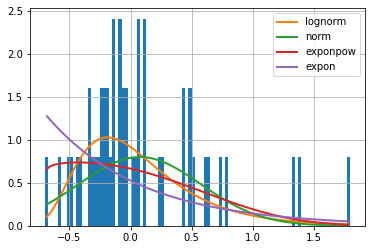

In [ ]:
fact1.summary()

In [ ]:
ret_act2 = retornos.iloc[:,1]
fact2 = Fitter(ret_act2, distributions= ['norm','lognorm','expon','exponpow'])
fact2.fit()
emp_dist2 = fact2.get_best(method = 'sumsquare_error')
emp_dist2

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


{'lognorm': {'s': 0.14899207408237725,
  'loc': -2.3235221575552925,
  'scale': 2.410108241255829}}

In [ ]:
ret_act3 = retornos.iloc[:,2]
fact3 = Fitter(ret_act3, distributions= ['norm','lognorm','expon','exponpow'])
fact3.fit()
emp_dist3 = fact3.get_best(method = 'sumsquare_error')
emp_dist3

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


{'lognorm': {'s': 0.1834507772525375,
  'loc': -1.528262569191667,
  'scale': 1.5537076334230933}}

In [ ]:
ret_act4 = retornos.iloc[:,3]
fact4 = Fitter(ret_act4, distributions= ['norm','lognorm','expon','exponpow'])
fact4.fit()
emp_dist4 = fact4.get_best(method = 'sumsquare_error')
emp_dist4

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 12.85it/s]


{'lognorm': {'s': 0.06429615691836889,
  'loc': -0.2264214642179629,
  'scale': 0.22594746397836826}}